0. Set Up

In [1]:

!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 5907, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 5907 (delta 300), reused 328 (delta 198), pack-reused 5441 (from 1)
Receiving objects: 100% (5907/5907), 631.00 MiB | 49.09 MiB/s, done.
Resolving deltas: 100% (3868/3868), done.
Updating files: 100% (178/178), done.


Install packages, (needs to be executed twice because of a bug in pip. exucute, restart the kernel and re-execute this cell)

In [1]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

!pip install pynrrd
!pip install -U ipywidgets
print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=009a21e5e86cb8f691d7edb3299d9b02e31b980def99f7faad2255b019c26171
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9l8kg9h/wheels/b0/6a/69/c66c8a74253f8baa35c990caf2c48f3d36ded6d5a7d58f0e62
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
['/content/Demeter_metamorphosis', 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

## 0.2 After jupyter restart, run:

In [1]:
# %matplotlib widget

import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



['/content/Demeter_metamorphosis/', '/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis', '/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src', '/home/turtlefox/anaconda3/envs/demeter_env/lib/python312.zip', '/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12', '/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/lib-dynload', '', '/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages', '/home/turtlefox/Documents/11_metamorphoses/DiffeoElasticity/src']


# 1. Code utile

In [1]:
import os
# import nibabel as nib
# import numpy as np
import torch
# from torch.cuda import OutOfMemoryError, device
#
import demeter.utils.torchbox as tb
# import demeter.utils.axes3dsliders_plt as a3s
import demeter.utils.rigid_exploration as rg
# ## Faire Recalage Rigid + Meta
import demeter.utils.reproducing_kernels as rk
import matplotlib.pyplot as plt
#
# # %load_ext autoreload
# # %autoreload 2
import demeter.metamorphosis as mt
import demeter.metamorphosis.rotate as mtrt


# from nibabel.processing import resample_from_to
#
#
# import subprocess
# from execute_ixi_template import *
# cwd = subprocess.check_output("pwd", text=True).strip()

import execute_ixi_template as eit

saves_overview.csv


## Open images

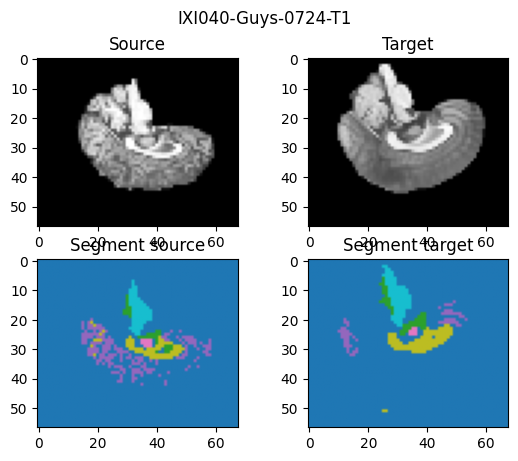

IXI040-Guys-0724-T1


In [2]:
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if "content" in cwd:
    template_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
    ixi_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
    template_seg_path = ""
    location = "colab"
elif "gpfs" in cwd:
    template_folder = "/gpfs/workdir/francoisa/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
    ixi_folder = "/gpfs/workdir/francoisa/data/IXI-T1_fastsurfer/"
    template_seg_path = "fastsurfer_seg/mri/"
    result_folder = "/gpfs/workdir/francoisa/data/IXI_results/"
    location = 'meso'
    # OPTIM_SAVE_DIR = "/gpfs/workdir/francoisa/saved_optim/"
else:
    template_folder ="/home/turtlefox/Documents/11_metamorphoses/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
    ixi_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI-T1_fastsurfer"
    template_seg_path = "fastsurfer_seg/mri/"
    result_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI_results/"
    location = 'local'
device = "cuda:0"

pp = eit.IXIToTemplatePreprocessor(
    ixi_root=ixi_folder,
    template_root=template_folder,
    template_seg_path=template_seg_path,
    do_plot=True,
)

subjects_numbers = [40]#, 28, 26, 50,2, 12]
RECOMPUTE = False
RESIZE_FACTOR = .8 if location == 'meso' else .8

# init_csv(result_folder)

if location == "meso": # don't touch this line
    file_db = "ixi_results_tests.db"
else: # here you can sandbox what you need to do.
    # file_db = "ixi_results.db"
    file_db = "ixi_results_meso_20250917.db"
db_path = os.path.join(result_folder, file_db)

subject_name, source, target, seg_source, seg_target = pp.get_subjects_aligned(numbers=40, resize_factor=0.3, first_only=True)
print(subject_name)

## Recherche rigide


In [7]:
# Recherche rigide
source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)
id_grid = tb.make_regular_grid(source_b.shape[2:],dx_convention="2square")
seg_target_b = tb.imgDeform(seg_target, (id_grid + trans_t), mode="nearest")
seg_source_b = tb.imgDeform(seg_source, (id_grid + trans_s), mode="nearest")

S compute barycentre : tensor([0.0117, 0.0268, 0.0003])
T compute barycentre : tensor([-0.0024, -0.0352, -0.0858])
diff :  tensor([-0.0141, -0.0620, -0.0861])


In [8]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_MutualInformation_Cost(target_b.to('cuda:0'), alpha=1)


mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)
top_params = rg.initial_exploration(mr,r_step=10, max_output = 15, verbose=True)
print(top_params)

[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 0.84 MB | Max Reserved: 2.00 MB
Init search : 1 / 50
dict_keys(['momentum_R', 'momentum_S'])


The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)


	 (tensor(6412.2700), tensor([-3.1416,  0.0000,  0.0000]))
Init search : 2 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6284.1187), tensor([-3.1416,  0.7854,  0.0000]))
Init search : 3 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(5902.3413), tensor([-3.1416,  1.5708,  0.0000]))
Init search : 4 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(5817.2983), tensor([-3.1416,  2.3562,  0.0000]))
Init search : 5 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6357.5620), tensor([-3.1416,  3.1416,  0.0000]))
Init search : 6 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6555.3364), tensor([-2.4435,  0.0000,  0.0000]))
Init search : 7 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6570.5205), tensor([-2.4435,  0.7854,  0.0000]))
Init search : 8 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6223.9678), tensor([-2.4435,  1.5708,  0.0000]))
Init search : 9 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6260.0215), tensor([-2.4435,  

In [9]:
best_loss, best_momentum_R, best_momentum_T, best_momentum_S, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)


>>>>>>>>>>
0/15 Optimize wit params [1.7453292608261108, 0.7853981852531433, 0.0]
momenta type <class 'dict'>
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 5272.16015625, ssd_rot = 5272.16015625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 5272.16015625, ssd_rot = 5272.16015625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 8053.1396484375, ssd_rot = 8053.1396484375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 3256.5625, ssd_rot = 3256.5625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 3156.3369140625, ssd_rot = 3156.3369140625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 3059.8544921875, ssd_rot = 3059.8544921875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 3053.8466796875, ssd_rot = 3053.8466796875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 3047.89208984375, ssd_rot = 3047.89208984375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1] :
	ssd = 3041.98779296875, ssd_rot = 3041.98779296875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 1

In [7]:
best_momentum_R = torch. tensor([[-0.0418, -0.1997,  0.0224],
        [ 0.1988, -0.0414,  0.0215],
        [-0.0291, -0.0109, -0.0010]])
best_momentum_T = torch. tensor([-0.0040, -0.0030,  0.0015])
best_momentum_S = torch. tensor([0.1479, 0.0832, 0.0471])
best_rotation = torch.tensor([[-0.3807,  0.9247, -0.0035],
        [-0.9247, -0.3807,  0.0040],
        [ 0.0024,  0.0048,  1.0000]])

## Check rigid search

tensor([[-0.0004,  0.0189,  0.0050],
        [-0.0194, -0.0360,  0.1860],
        [ 0.0024, -0.1860, -0.0356]], requires_grad=True)
tensor([ 0.0016, -0.0060, -0.0110], requires_grad=True)
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 19.75 MB | Max Reserved: 72.00 MB
Estimated affines values:
	 rotation matrix : tensor([[ 9.9982e-01,  1.8944e-02,  3.0833e-03],
        [-1.9187e-02,  9.8254e-01,  1.8504e-01],
        [ 4.7600e-04, -1.8507e-01,  9.8273e-01]], grad_fn=<MmBackward0>)
	 translation : tensor([ 0.0016, -0.0062, -0.0118], grad_fn=<AddBackward0>)
	 scaling : tensor([1.1143, 1.1132, 1.1786], grad_fn=<MulBackward0>)
	 (rotation only) dice val 1.0 : 0.46255508065223694
	 (rotation only) dice val 2.0 : 0.4582436978816986
	 (rotation only) dice val 3.0 : 0.6898469924926758
	 (rotation only) dice val 4.0 : 0.6273022890090942
	 (rotation only) dice val 5.0 : 0.7000705599784851
	 (rotation only) dice average : 0.5876036882400513
Rigid dice : {'(rotation only) dice val 1.0': tenso

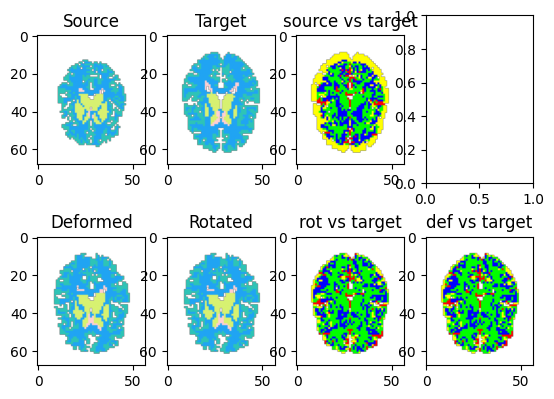

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001192092896].


rigid_dice: {'(rotation only) dice val 1.0': tensor(0.4626), '(rotation only) dice val 2.0': tensor(0.4582), '(rotation only) dice val 3.0': tensor(0.6898), '(rotation only) dice val 4.0': tensor(0.6273), '(rotation only) dice val 5.0': tensor(0.7001), '(rotation only) dice average': tensor(0.5876)}
reg_dice: {'(all) dice val 1.0': tensor(0.4626), '(all) dice val 2.0': tensor(0.4582), '(all) dice val 3.0': tensor(0.6898), '(all) dice val 4.0': tensor(0.6273), '(all) dice val 5.0': tensor(0.7001), '(all) dice average': tensor(0.5876)}


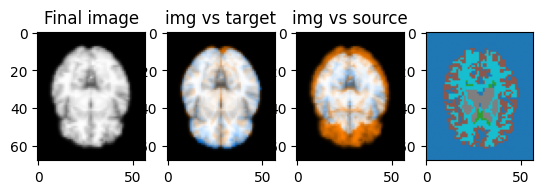

In [10]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    source_b.shape,
    image=False,
    rotation=True,
    translation=True,
    scaling=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),# - trans_s + trans_t,
    scale_prior=best_momentum_S.detach().clone(),
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source_b.cpu(), momenta, save=True)

# mr.id_grid = mr.mp.id_grid
# mr.parameter = momenta
# mr.cost(momenta)
print('Estimated affines values:')
print("\t rotation matrix :", mr.mp.rot_mat)
print("\t translation :", mr.mp.translation)
print("\t scaling :", mr.mp.scale)

(rigid_dice, reg_dice), (rotated_source_segs, deformed_source_segs) = mr.compute_DICE(seg_source_b, seg_target_b)
print("rigid_dice:", rigid_dice)
print("reg_dice:", reg_dice)

# Hack un peu sale
# mr.to_analyse = (momenta, torch.zeros((4,1)))
# mr.save(f"{name}_ixibrain_rigidscalingonly",
        # save_path="/content/drive/MyDrive/demeter_data/demeter_optim/"
        # )


# a3s.Visualize_GeodesicOptim_plt(mr, "random")
rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
rot_def += mr.mp.translation
rot_def = mr.mp.get_rigidor()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')

img = rotated_source[0,0, mr.source.shape[-3]//2 -4].detach().cpu()
img_target = tb.imCmp(rotated_source[:,:, source.shape[-3]//2 -4].detach().cpu(), mr.target[:,:, source.shape[-3]//2 -4].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[:,:, source.shape[-3]//2 -4].detach().cpu(), mr.source[:,:, source.shape[-3]//2 -4].detach().cpu(), "compose")[0]

fig,ax = plt.subplots(1,4)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
ax[3].imshow(rotated_source_segs.detach()[0,0,  source.shape[-3]//2],
             cmap="tab10",
             # vmin=rotated_source.min(),
             # vmax=rotated_source.max()
             )

plt.show()

## LDDMM

Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| 2457352478.py:19 in <module>
    {'momentum_I': tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               ...,
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.]],
    
              [[0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               ...,
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.]],
    
              [[0., 0., 0.,  ..., 0., 0., 0.],
               [0., 0., 0.,  ..., 0., 0., 0.],
             

True
True
True
True
momenta type <class 'dict'>
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 1604.01220703125, ssd_rot = 1604.01904296875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 1604.01220703125, ssd_rot = 1604.01904296875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 42195.6015625, ssd_rot = 1603.8187255859375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 2985.85791015625, ssd_rot = 1603.992431640625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 625.7401733398438, ssd_rot = 1604.009765625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 568.2615966796875, ssd_rot = 1604.01025390625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 532.54638671875, ssd_rot = 1604.003662109375
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 523.146728515625, ssd_rot = 1604.004638671875
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	ssd = 507.917236328125, ssd_rot = 1603.998291015625
	[DataCost  :(Rotation_Ssd_Cost) alpha = 0.3] :
	s

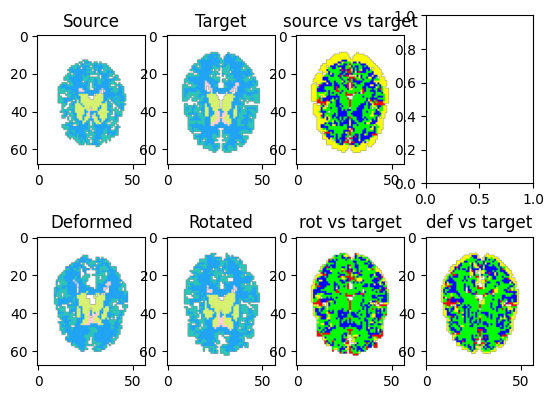

residual min -0.0 max -0.0


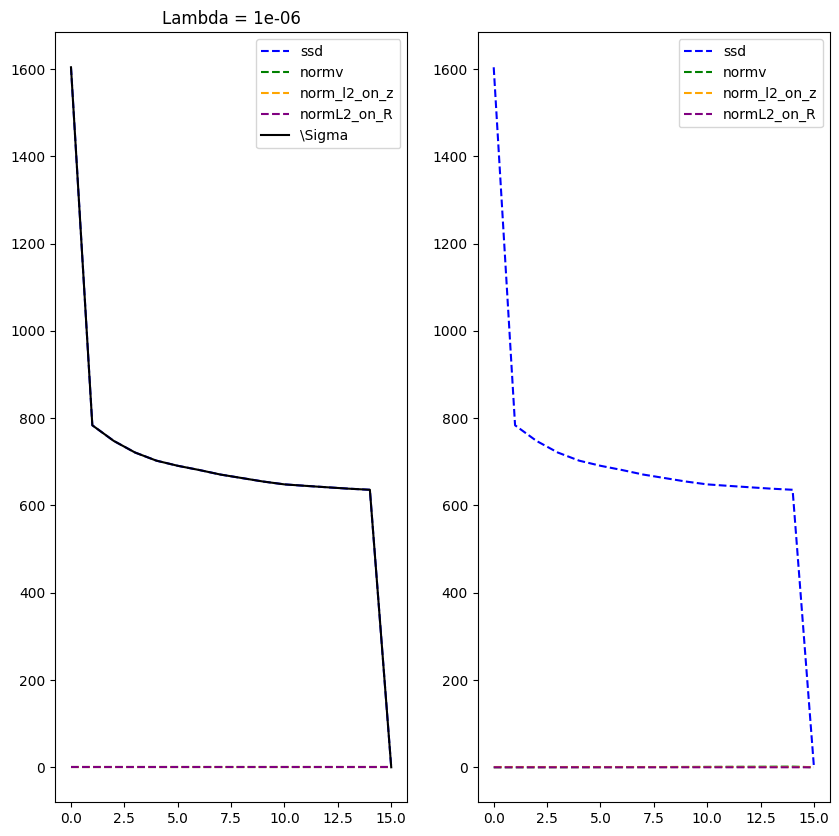

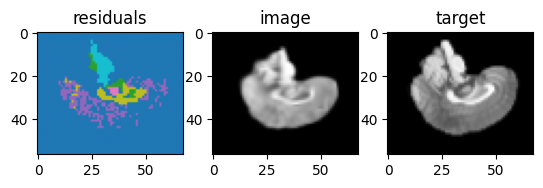

In [11]:

from datetime import datetime

sigma= [3, 5, 7]
sigma = [(s,)*3 for s in sigma]
kernelOperator = rk.Multi_scale_GaussianRKHS(sigma, normalized=False)

ic(momenta)

alpha = .3
rho = 1
cost_cst = .1
integration_steps = 10

datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=alpha)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)
momenta = mt.prepare_momenta(
    source_b.shape,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
    scale_prior=best_momentum_S.detach().clone(),
)

mr = mt.rigid_along_metamorphosis(
  source_b, target_b, momenta_ini=momenta,
  kernelOperator= kernelOperator,
  rho = rho,
  data_term=datacost ,
  integration_steps = integration_steps,
  cost_cst=cost_cst,
  n_iter=15,
  save_gpu_memory=False,
  lbfgs_max_iter = 20,
  lbfgs_history_size = 20,
)

dices, _ =mr.compute_DICE(seg_source_b, seg_target_b, verbose=True)
dice = dices[0] | dices[1]

file_save, path = mr.save(f"{subject_name}_rigid_along_lddmm",
                    light_save=True,
                    save_path = os.path.join(result_folder, "rigid_along_lddmm")
)
now = datetime.now()
eit.log_metrics(
    patient_id=subject_name,
    method="rigid_along_LDDMM",
    metrics={'rigid_along_LDDMM ' + k: v for k,v in dice.items()},
    run_id= str(now) + ' at ' + location,
    step=0,
meta={"gpu":torch.cuda.get_device_name(),
                      "alpha" : alpha,
                      "rho" : rho,
                      "cost_cst" : cost_cst,
                        "sigma" : sigma, 
                      "integration_steps" : integration_steps,
                      "file": os.path.join(path, file_save)
                      }
)

# fig, ax = plt.subplots(1,3)
T, _, D, H, W = source.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2
fig, ax = plt.subplots(1,3)
ax[0].imshow(deformed_source_segs[0,0,..., slice_index].detach().cpu(), cmap='tab10')
ax[0].set_title(f'residuals')
ax[1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[1].set_title(f'image')

ax[2].imshow(mr.target[0,0,..., slice_index], cmap='gray')
ax[2].set_title(f'target')
plt.show()

In [ ]:
a3s.Visualize_GeodesicOptim_plt(mr, f"{name}_metaRigid_rho{rho}")


In [15]:

mr.save(f"{name}_ixibrain_rigidscalingLDDMM_colab",
        # save_path="/content/drive/MyDrive/demeter_data/demeter_optim/"
        )


/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/abstract.py:1574: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(path)
ic| abstract.py:1574 in save()
    '/home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/'



BUG WARNING : An other data term than Ssd was detectedFor now our method can't save it, it is ok to visualisethe optimisation, but be careful loading the optimisation.

Optimisation saved in /home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/3D_20250902_IXI002_to_template_ixibrain_rigidscalingLDDMM_colab_turtlefox_000.pk1 



('3D_20250902_IXI002_to_template_ixibrain_rigidscalingLDDMM_colab_turtlefox_000.pk1',
 '/home/turtlefox/.local/share/Demeter_metamorphosis/saved_optim/')